# 1. Link ATAC-seq peaks to expression 

The ATAC-seq gives information about peak intensities per sample and the RNA-seq gives gene expression levels per sample. Wen want to correlate between chromatin and expresion.

We will answer the questions:
- Does this regulatory region (peak) affect this gene?
- Is that relationship consistent across many samples?

Before starting, I want to make sure that ATAC-seq and the RNA-seq datasets align to enable further analysis.

In [24]:
import pandas as pd

# Loading the data
atac_peak_matrix = pd.read_csv("ATAC-seq/filtered_ATAC_abT_Tact_Stem.csv")
atac_signal_matrix = atac_peak_matrix.iloc[:, 8:]  # dropping metadata columns
atac_transposed_df = atac_signal_matrix.T

rna_df = pd.read_csv("rna_filtered_abT_Tact_Stem.csv", index_col=0)
rna_df.T
rna_transposed_df = rna_df.T

from sklearn.preprocessing import StandardScaler
rna_scaled_array = StandardScaler().fit_transform(rna_transposed_df)
rna_scaled_df = pd.DataFrame(rna_scaled_array, index=rna_transposed_df.index, columns=rna_transposed_df.columns)

# Ensuring sample alignment
common_samples = atac_transposed_df.index.intersection(rna_scaled_df.index)
atac = atac_transposed_df.loc[common_samples]
rna = rna_scaled_df.loc[common_samples]

We can only correlate ATAC and RNA from the same samples. That is why we did the sample alignment so that both matrices refer to the same cell type.

Before continuing we want to make sure that this alignment worked correctly.

In [25]:
# Making sure datasets are aligned
## Comparing shapes
print("ATAC shape:", atac.shape)
print("RNA shape:", rna.shape)

## Comparing indices
for sample_a, sample_r in zip(atac.index, rna.index):
    print(f"ATAC: {sample_a}  |  RNA: {sample_r}")

## Inspecting common samples 
print("Common samples used for correlation:")
print(list(common_samples))


ATAC shape: (28, 512595)
RNA shape: (28, 17535)
ATAC: preT.DN1.Th  |  RNA: preT.DN1.Th
ATAC: preT.DN2a.Th  |  RNA: preT.DN2a.Th
ATAC: preT.DN2b.Th  |  RNA: preT.DN2b.Th
ATAC: preT.DN3.Th  |  RNA: preT.DN3.Th
ATAC: T.DN4.Th  |  RNA: T.DN4.Th
ATAC: T.ISP.Th  |  RNA: T.ISP.Th
ATAC: T.DP.Th  |  RNA: T.DP.Th
ATAC: T.4.Th  |  RNA: T.4.Th
ATAC: T.8.Th  |  RNA: T.8.Th
ATAC: T.4.Nve.Sp  |  RNA: T.4.Nve.Sp
ATAC: T.4.Nve.Fem.Sp  |  RNA: T.4.Nve.Fem.Sp
ATAC: T.4.Sp.aCD3+CD40.18hr  |  RNA: T.4.Sp.aCD3+CD40.18hr
ATAC: T.8.Nve.Sp  |  RNA: T.8.Nve.Sp
ATAC: Treg.4.25hi.Sp  |  RNA: Treg.4.25hi.Sp
ATAC: Treg.4.FP3+.Nrplo.Co  |  RNA: Treg.4.FP3+.Nrplo.Co
ATAC: T8.TN.P14.Sp  |  RNA: T8.TN.P14.Sp
ATAC: T8.TE.LCMV.d7.Sp  |  RNA: T8.TE.LCMV.d7.Sp
ATAC: T8.MP.LCMV.d7.Sp  |  RNA: T8.MP.LCMV.d7.Sp
ATAC: T8.Tcm.LCMV.d180.Sp  |  RNA: T8.Tcm.LCMV.d180.Sp
ATAC: T8.Tem.LCMV.d180.Sp  |  RNA: T8.Tem.LCMV.d180.Sp
ATAC: NKT.Sp  |  RNA: NKT.Sp
ATAC: NKT.Sp.LPS.3hr  |  RNA: NKT.Sp.LPS.3hr
ATAC: NKT.Sp.LPS.18hr  |  RNA: NKT

We have established that the datasets align. 

Now, want to create a gene -> TSS coordinate table to be able to annotate the peaks later. We are using the annotations file (refFlat) for this step.

In [26]:
ref = pd.read_csv("refFlat", sep="\t", header=None)
ref.head()
ref.shape
len(ref)

47382

In [27]:
import pandas as pd
from scipy.spatial import cKDTree

# Loading and naming refFlat columns 
ref = pd.read_csv("refFlat", sep="\t", header=None)

ref.columns = [
    "gene_name", "transcript_id", "chrom", "strand",
    "tx_start", "tx_end", "cds_start", "cds_end",
    "exon_count", "exon_starts", "exon_ends"
]

# Computing strand-aware TSS 
ref["tss"] = ref.apply(
    lambda row: row["tx_start"] if row["strand"] == "+" else row["tx_end"],
    axis=1
)

# Keeping one TSS per gene
tss_table = ref.groupby("gene_name").first().reset_index()
tss_table = tss_table[["gene_name", "chrom", "tss", "strand"]].rename(columns={"gene": "gene_symbol"})

print("TSS table shape:", tss_table.shape)
tss_table.head()


TSS table shape: (26214, 4)


,gene_name,chrom,tss,strand
0,0610005C13Rik,chr7,45575176,-
1,0610009B22Rik,chr11,51688634,-
2,0610009E02Rik,chr2,26445923,+
3,0610009L18Rik,chr11,120348677,+
4,0610010F05Rik,chr11,23633631,-


Now, we want to match ATAC peaks to nearest TSS. For that, we will find the nearest gene to each peak and compute the distance to that gene's TSS. We will use KD-Tree for this. It will give us information about which gene is likely regulated by which peak.

In [28]:
# Loading ATAC peak file
peaks = pd.read_csv("peaks_tss_distance.csv") 
peaks = peaks.rename(columns={"ImmGenATAC1219.peakID": "peak_id"})

# Create BED-style table 
peak_table = peaks[["peak_id", "chrom", "peak_center"]].copy()
peak_table["start"] = peak_table["peak_center"]
peak_table["end"] = peak_table["peak_center"] + 1  # peak summit +1 bp to make it computable

# Matching each peak to the nearest TSS
from scipy.spatial import cKDTree

tss_links = []

for chrom in peak_table["chrom"].unique():
    peaks_chr = peak_table[peak_table["chrom"] == chrom]
    tss_chr = tss_table[tss_table["chrom"] == chrom]

    if tss_chr.empty:
        continue

    # Using KDTree for fast nearest-neighbor matching
    tree = cKDTree(tss_chr["tss"].values.reshape(-1, 1))
    dists, idxs = tree.query(peaks_chr["peak_center"].values.reshape(-1, 1), k=1)

    matched_genes = tss_chr.iloc[idxs]["gene_name"].values
    matched_tss = tss_chr.iloc[idxs]["tss"].values
    matched_strands = tss_chr.iloc[idxs]["strand"].values

    result = peaks_chr.copy()
    result["gene_symbol"] = matched_genes
    result["tss"] = matched_tss
    result["strand"] = matched_strands
    
    # Computing signed distance to TSS based on strand
    result["signed_distance_to_tss"] = result.apply(
        lambda row: row["peak_center"] - row["tss"] if row["strand"] == "+" else row["tss"] - row["peak_center"],
        axis=1
    )

    # Keeping absolute value for safety
    result["distance_to_tss"] = result["signed_distance_to_tss"].abs()
    
    tss_links.append(result)

linked_df = pd.concat(tss_links, ignore_index=True)

# Saving result
linked_df.to_csv("peak_to_gene_annotated.csv", index=False)


The BED-style table refers to a table representing genomic features. It is used to standardize genomic region representation. Here, it represents ATAC peaks as genomic coordinated and matches each peak to the nearest TSS using spatial distance. This distance is computed as the difference between the peak summit and the TSS position on the same chromosome. We also added differentiation between up- and downstream elements. 

We can now link peaks to genes by correlating chromatin accessibility with gene expression across the 28 samples. Because there were a lot of errors that needed fixing, in this first cell I am reloading the datasets and aligning them again.

In [29]:
# Re-loading full ATAC matrix with metadata
full_atac = pd.read_csv("ATAC-seq/filtered_ATAC_abT_Tact_Stem.csv")

# Extracting signal matrix and assigning peak IDs as index
atac_signal_matrix = full_atac.iloc[:, 8:]  # signal: shape (512595 rows, 29 columns)
atac_signal_matrix.index = full_atac["ImmGenATAC1219.peakID"].astype(str)  # assigning to rows

# Transposing so rows = samples, columns = peak IDs
atac_transposed_df = atac_signal_matrix.T  # shape = (29 samples, 512595 peaks)

# Aligning with RNA
common_samples = atac_transposed_df.index.intersection(rna_scaled_df.index)
atac = atac_transposed_df.loc[common_samples]
rna = rna_scaled_df.loc[common_samples]


In [30]:
print("Signal matrix shape (rows = peaks):", atac_signal_matrix.shape)
print("First 5 peak IDs (index):", atac_signal_matrix.index[:5].tolist())


Signal matrix shape (rows = peaks): (512595, 29)
First 5 peak IDs (index): ['ImmGenATAC1219.peak_1', 'ImmGenATAC1219.peak_2', 'ImmGenATAC1219.peak_3', 'ImmGenATAC1219.peak_4', 'ImmGenATAC1219.peak_5']


In [31]:
atac_transposed_df = atac_signal_matrix.T
common_samples = atac_transposed_df.index.intersection(rna_scaled_df.index)
atac = atac_transposed_df.loc[common_samples]
rna = rna_scaled_df.loc[common_samples]


In [32]:
import pandas as pd
from scipy.stats import spearmanr
from tqdm import tqdm

# Loading the peak–TSS annotated file with signed distances
annot = pd.read_csv("peak_to_gene_annotated.csv")

# Filtering to peaks within ±100 kb
annot = annot[annot["signed_distance_to_tss"].abs() <= 100000]

# Ensuring strings for matching
annot["peak_id"] = annot["peak_id"].astype(str)
annot["gene_symbol"] = annot["gene_symbol"].astype(str)
atac.columns = atac.columns.astype(str)
rna.columns = rna.columns.astype(str)

# Keeping only peak–gene pairs present in both matrices
filtered_map = annot[
    annot["peak_id"].isin(atac.columns) & 
    annot["gene_symbol"].isin(rna.columns)
]

# Correlating peak signal vs. gene expression across all samples
results = []

for _, row in tqdm(filtered_map.iterrows(), total=len(filtered_map)):
    peak = row["peak_id"]
    gene = row["gene_symbol"]
    dist = row["signed_distance_to_tss"]  # direction-aware

    try:
        rho, pval = spearmanr(atac[peak], rna[gene])
        results.append({
            "peak_id": peak,
            "gene_symbol": gene,
            "signed_distance_to_tss": dist,
            "spearman_rho": rho,
            "pval": pval
        })
    except Exception:
        continue

# Saving full results
cor_df = pd.DataFrame(results)
cor_df.to_csv("all_peak_gene_correlations.csv", index=False)

# Filtering for significant & strong correlations
linked_peaks = cor_df[
    (cor_df["pval"] < 0.05) & (cor_df["spearman_rho"].abs() > 0.5)
]
linked_peaks.to_csv("significant_peak_gene_links.csv", index=False)


100%|██████████| 9535171/9535171 [1:13:51<00:00, 2151.59it/s]


In this code, filtered_map contains peak-gene pairs, that is same gene and peak existing in the data that are within +/- 100 kb of each other. For each pair we compute the genomic distance between the peak and the gene. 

The Spearman correlation compares the chromatin accessibility (ATAC) with the gene expression level (RNA) across samples and then computes the Spearman correlation coefficient (non-parametric) and the p-value which indicated statistical significance. This information is saved in "all_peak_gene_correlation.csv".

In the last step, we filtered for the stron significant links only. This means we keep those links where the correlation is strong |ρ| > 0.5 and statistically significant p < 0.05. The file containing this is called "significant_peak_gene_links.csv"

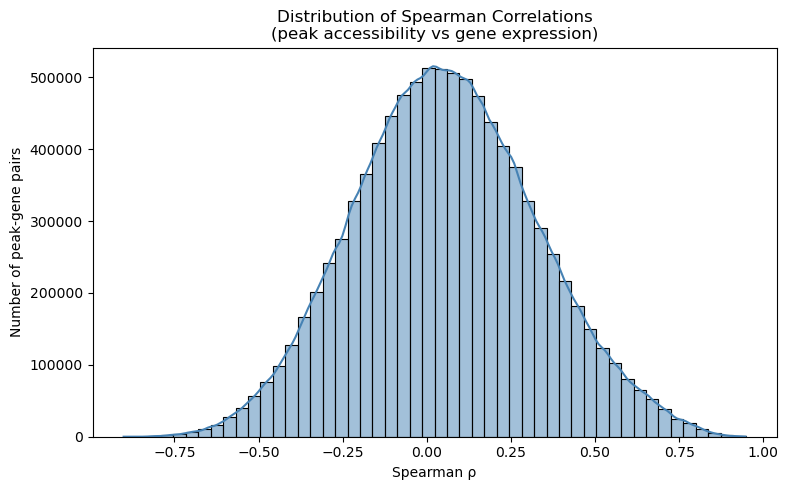

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(cor_df["spearman_rho"], bins=50, kde=True, color="steelblue")
plt.title("Distribution of Spearman Correlations\n(peak accessibility vs gene expression)")
plt.xlabel("Spearman ρ")
plt.ylabel("Number of peak-gene pairs")
plt.tight_layout()
plt.show()


**Fig. 1: Distribution of Spearman correlations (peak accessibility vs gene expression)**

The histogramm shows us that most peaks do not regulate their nearest gene. This is not really surprising considering that many assigned peaks are probably not real regulators of their assigned gene. However, the tails on both ends (ρ > 0.5 or ρ < -0.5) do show strong positive or negative correlations and most likely represent functional regulatory interactions. 

ρ > 0.5 → accessibility increases with expression → potential enhancers

ρ < -0.5 → accessibility decreases with expression → possible repressors

**analyse them separately**

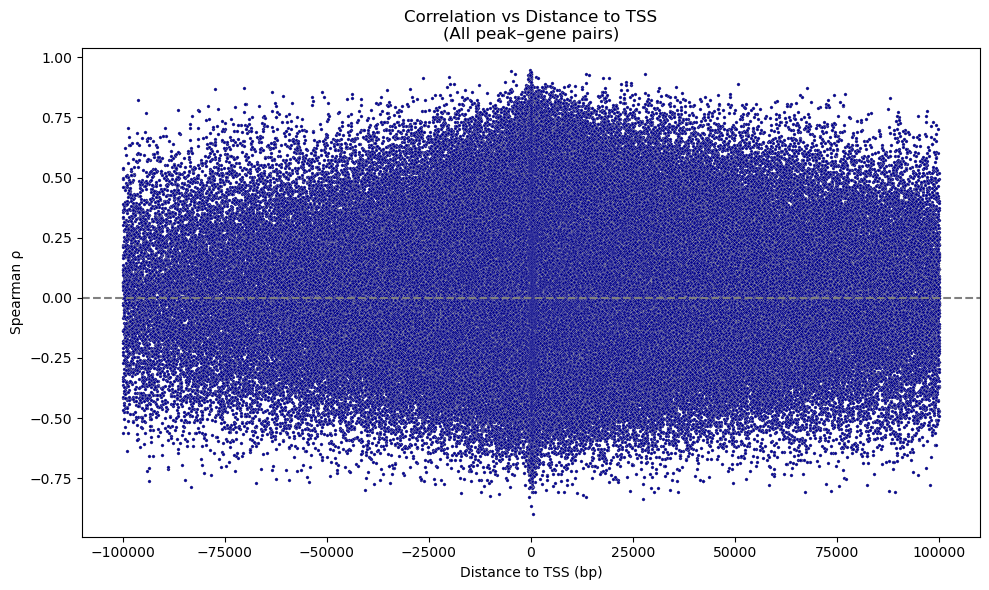

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=cor_df,
    x="signed_distance_to_tss",
    y="spearman_rho",
    alpha=0.1,
    s=5,
    color="darkblue"
)

plt.title("Correlation vs Distance to TSS\n(All peak–gene pairs)")
plt.xlabel("Distance to TSS (bp)") # distance from the peak summit to the TSS
plt.ylabel("Spearman ρ") # Spearman correlation between peak summit and expression of nearest gene
plt.axhline(0, color="gray", linestyle="--")
plt.tight_layout()
plt.show()

**Fig. 2: Correlation vs Distance to TSS (all peak-gene pairs)**

This plot confirms our expections - the most peak-gene pairs are located close to the gene-TSS, possibily proximal CREs with a direct regulatory effect on gene expression. With increasing distance to TSS the vertical spread decreases which is expected as those peaks have weaker correlations with gene expression.

# 2. Where are CREs located with respect to TSS?

We want to classify peaks based on genomic location relative to the TSS:
- promoter
- proximal enhancer
- distal enhancer
- intergenic/intronic

The first step is to classify each CRE by distance to TSS. 